In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255, brightness_range=[0.2,0.7])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 2015 images belonging to 112 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224),batch_size=8, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
from keras.applications.densenet import DenseNet121

In [ ]:
conv_base = DenseNet121(weights = 'imagenet', include_top = False)

29089792/29084464 [==============================] - 2s 0us/step


In [ ]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:411]:
   layer.trainable = False
for layer in conv_base.layers[411:]:
   layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn True
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn True
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn True
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn True
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn True
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn True
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn True
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn True
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn True
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn True
36 conv2_block5_0_relu False
37 conv2_block5_1_conv False

In [ ]:
model = Sequential()

In [ ]:
from keras.layers import Input

In [ ]:
input_tensor = Input(shape=(224,224,1))
x = Conv2D(3, (3,3), padding='same')(input_tensor)
ouput = conv_base(x)
models = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
model.add(models)

In [ ]:
model.add(Flatten())

In [ ]:
model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(112, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 7, 7, 1024)        7037534   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              102762496 
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               229488    
Total params: 110,029,518
Trainable params: 103,399,246
Non-trainable params: 6,630,272
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/GreyScale_Desnet121.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=252,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 18.3718 - accuracy: 0.0194
Epoch 00001: val_loss improved from inf to 6.80768, saving model to /content/drive/My Drive/1-piece/GreyScale_Desnet121.h5
252/252 [==============================] - 2158s 9s/step - loss: 18.3718 - accuracy: 0.0194 - val_loss: 6.8077 - val_accuracy: 0.0268
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 6.5533 - accuracy: 0.0213
Epoch 00002: val_loss improved from 6.80768 to 6.22282, saving model to /content/drive/My Drive/1-piece/GreyScale_Desnet121.h5
252/252 [==============================] - 112s 446ms/step - loss: 6.5533 - accuracy: 0.0213 - val_loss: 6.2228 - val_accuracy: 0.0357
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 6.0820 - accuracy: 0.0109
Epoch 00003: val_loss improved from 6.22282 to 5.79161, saving model to /content/drive/My Drive/1-piece/GreyScale

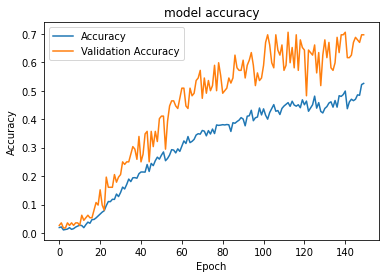

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

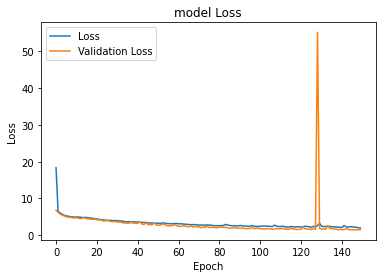

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([ 24,   1,   1,   3,   4,   5,   6,   7,   8,  10,  10,  11,  23,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        25,  26,  17,  26,  30,  36,  32,  33,  34,  35,  36,  37,  54,
        39,  40,  41,  42,  43,  61,  77,  46,  48,  48,  49,  87,  67,
        67,  64,  54,  55,  51,  57,  58,  18,  60,  61,  84,  97,  64,
        67,  66,  67,  66,  69,  70,  67,  72,  73,  74,  59,  52,  82,
        78,  79,  80,  72,  82,  83,  74, 110,  46,  87,  88,  47, 111,
        92,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 105,
       104, 105,  84, 111, 108,  67,  84, 111])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.6517857142857143


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.5446428571428571


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.6517857142857143


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.5784438775510204


**Processing for Colour Data**

In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8)

Found 2015 images belonging to 112 classes.


In [ ]:
Colour_ValidData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224), batch_size=8)

Found 112 images belonging to 112 classes.


In [ ]:
conv_base_colour = DenseNet121(weights = 'imagenet', include_top = False)

In [ ]:
for layer in conv_base_colour.layers[:299]:
  layer.trainable = False
for layer in conv_base_colour.layers[299:]:
  layer.trainable = True
for layer in conv_base_colour.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

print("Done")

Done


In [ ]:
for i, layer in enumerate(conv_base_colour.layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 zero_padding2d_2 False
2 conv1/conv False
3 conv1/bn True
4 conv1/relu False
5 zero_padding2d_3 False
6 pool1 False
7 conv2_block1_0_bn True
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn True
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn True
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn True
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn True
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn True
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn True
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn True
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn True
36 conv2_block5_0_relu False
37 conv2_block5_1_conv Fal

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,3))

In [ ]:
ouput = conv_base_colour(input_tensor)

In [ ]:
models = Model(inputs = input_tensor, outputs = ouput)

In [ ]:
model_colour = Sequential()

In [ ]:
model_colour.add(models)

In [ ]:
model_colour.add(Flatten())

In [ ]:
model_colour.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_colour.add(Dropout(0.5))
model_colour.add(Dense(112, activation='softmax'))

In [ ]:
model_colour.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/Colour_Desnet121.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=252,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 2.3486 - accuracy: 0.4372
Epoch 00001: val_loss improved from inf to 1.58651, saving model to /content/drive/My Drive/1-piece/Colour_Desnet121.h5
252/252 [==============================] - 92s 365ms/step - loss: 2.3486 - accuracy: 0.4372 - val_loss: 1.5865 - val_accuracy: 0.6607
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 2.2193 - accuracy: 0.4630
Epoch 00002: val_loss improved from 1.58651 to 1.44452, saving model to /content/drive/My Drive/1-piece/Colour_Desnet121.h5
252/252 [==============================] - 98s 390ms/step - loss: 2.2193 - accuracy: 0.4630 - val_loss: 1.4445 - val_accuracy: 0.6696
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 2.2347 - accuracy: 0.4784
Epoch 00003: val_loss did not improve from 1.44452
252/252 [==============================] - 87s 346ms/step - loss: 2.2347 - accuracy: 0.4784 - val_loss: 1.4672 - val_accuracy: 0.6964
Epoch 4/150


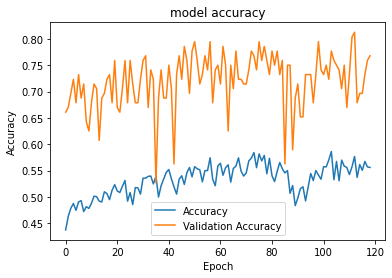

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

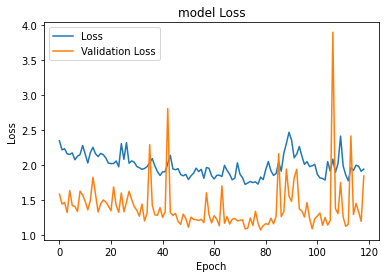

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 112 images belonging to 112 classes.


In [ ]:
Colour_predict = model_colour.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([ 55,  55, 110,  93,  88,  55,  61,  55,  61,  93,  55, 105,  55,
        97,  55,  55,  93,  55, 105,  55,  55,  55,  55,  55,  89,  93,
        55,  89,  90,  72,  55,  55,  72,  97,  55,  55,  55,  55,  55,
        55,  55,  55,  55,  55,  55,  55,  90, 107,  91,  55,  55,  55,
        55,  86,  55,  55,  55,  91,  55,  55,  89,  55,  55,  55,  55,
        55,  55,  55,  55,  55,  63, 105,  55,  55,  55,  88,  55,  42,
        55,  88,  55,  55,  55,  55,  55,  55,  55,  55,  55,  55,  55,
       107,  55,  55,  89,  55, 105,  97,  63,  55,  55,  55,  97,  55,
        55,  55,  55,  55,  55,  55,  55,  55])

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.017857142857142856


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.0023466117216117215


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.017857142857142856


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.00379746835443038


**Emsemble**

In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_Predict_classes

array([ 24,   1,   1,   3,   4,   5,   6,   7,   8,  10,  10,  11,  23,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        25,  26,  17,  26,  30,  36,  32,  33,  34,  35,  36,  37,  54,
        39,  40,  41,  55,  55,  61,  55,  46,  48,  48,  49,  87,  55,
        55,  64,  54,  55,  55,  57,  58,  55,  60,  61,  55,  55,  64,
        55,  66,  55,  66,  69,  70, 105,  72,  73,  55,  72,  55,  82,
        78,  79,  80,  55,  82,  83,  55,  55,  55,  87,  88,  47,  55,
        92,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,  55,
       104, 105,  55, 111,  55,  55,  55, 111])

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.6071428571428571


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.5182291666666666


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.6071428571428571


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.5453571428571429


In [ ]:
Second_final = 0.5* Colour_predict + 0.5* Grey_predict

In [ ]:
Second_Final_Predict_classes = np.argmax(Second_final, axis=1)

In [ ]:
Mean_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_Final_Predict_classes)
print("Colour Accuracy: ", Mean_Final_accuracy)

Colour Accuracy:  0.6339285714285714
